# Marketing Campaign Analysis

Identifying the most effective channels, audiences, and strategies to optimize ROI based on our dataset of 200 000 marketing campaigns.

Dataset: https://www.kaggle.com/datasets/manishabhatt22/marketing-campaign-performance-dataset

In [2]:
import pandas as pd                
import numpy as np                 
import matplotlib.pyplot as plt    

## Data Preparation

Cleaning and transforming campaign data for analysis.

In [3]:
df = pd.read_csv('marketing_campaign_dataset.csv', parse_dates=['Date'])

print(df.describe())

         Campaign_ID  Conversion_Rate            ROI         Clicks  \
count  200000.000000    200000.000000  200000.000000  200000.000000   
mean   100000.500000         0.080070       5.002438     549.772030   
min         1.000000         0.010000       2.000000     100.000000   
25%     50000.750000         0.050000       3.500000     325.000000   
50%    100000.500000         0.080000       5.010000     550.000000   
75%    150000.250000         0.120000       6.510000     775.000000   
max    200000.000000         0.150000       8.000000    1000.000000   
std     57735.171256         0.040602       1.734488     260.019056   

         Impressions  Engagement_Score                        Date  
count  200000.000000     200000.000000                      200000  
mean     5507.301520          5.494710  2021-07-01 23:35:09.600000  
min      1000.000000          1.000000         2021-01-01 00:00:00  
25%      3266.000000          3.000000         2021-04-02 00:00:00  
50%      5517.5

In [ ]:
# normalize column names to lowercase & underscores
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(' ', '_')
      .str.replace('-', '_')
)

# Columns are now:
# campaign_id, company, campaign_type, target_audience, duration,
# channel_used, conversion_rate, acquisition_cost, roi,
# location, language, clicks, impressions, engagement_score,
# customer_segment, date

# parse acquisition_cost to numeric (remove $ and commas)
df['acquisition_cost'] = (
    df['acquisition_cost']
      .str.replace(r'[\$,]', '', regex=True)
      .astype(float)
)

df['conversions'] = (df['conversion_rate'] * df['clicks']).round().astype(int)

df['revenue'] = df['acquisition_cost'] * (df['roi'] + 1)

df['ctr'] = df['clicks'] / df['impressions']

# convert duration (e.g 30 days) into integer days
df['duration_days'] = df['duration'].str.extract(r'(\d+)').astype(int)

df['day_of_week'] = df['date'].dt.day_name()

# check for missing values
print("Missing values:")
print(df.isna().sum())

df['rev_per_conv'] = df['revenue'] / df['conversions']

df['cost_per_conv'] = df['acquisition_cost'] / df['conversions']

# clean up infinities / NaNs
df.replace([np.inf, -np.inf], np.nan, inplace=True)

Missing values:
campaign_id         0
company             0
campaign_type       0
target_audience     0
duration            0
channel_used        0
conversion_rate     0
acquisition_cost    0
roi                 0
location            0
language            0
clicks              0
impressions         0
engagement_score    0
customer_segment    0
date                0
conversions         0
revenue             0
ctr                 0
duration_days       0
day_of_week         0
dtype: int64


## Channel Analysis

Comparing performance across marketing channels.

In [5]:
def summarize(group):
    return pd.Series({
        'campaigns'        : len(group),
        'impressions'      : group['impressions'].sum(),
        'clicks'           : group['clicks'].sum(),
        'conversions'      : group['conversions'].sum(),
        'revenue'          : group['revenue'].sum(),
        'acq_cost'         : group['acquisition_cost'].sum(),
        'ctr'              : group['clicks'].sum()/group['impressions'].sum(),
        'conversion_rate'  : group['conversions'].sum()/group['clicks'].sum(),
        'roi'              : (group['revenue'].sum()-group['acquisition_cost'].sum())
                              / group['acquisition_cost'].sum(),
        'rev_per_conv'     : group['revenue'].sum()/group['conversions'].sum(),
        'cost_per_conv'    : group['acquisition_cost'].sum()/group['conversions'].sum()
    })

In [6]:
# By channel
chan_summary = df.groupby('channel_used').apply(summarize).reset_index()
print("By Channel:\n", chan_summary, "\n")

By Channel:
   channel_used  campaigns  impressions      clicks  conversions       revenue  \
0        Email    33599.0  184801107.0  18493963.0    1485425.0  2.524644e+09   
1     Facebook    32819.0  180659428.0  18037947.0    1446338.0  2.474541e+09   
2   Google Ads    33438.0  185006879.0  18340807.0    1468717.0  2.516724e+09   
3    Instagram    33392.0  183738455.0  18316654.0    1462938.0  2.497101e+09   
4      Website    33360.0  183806353.0  18414628.0    1477660.0  2.504152e+09   
5      YouTube    33392.0  183448082.0  18350407.0    1463649.0  2.501105e+09   

      acq_cost       ctr  conversion_rate       roi  rev_per_conv  \
0  420874104.0  0.100075         0.080319  4.998573   1699.610689   
1  410595258.0  0.099845         0.080183  5.026715   1710.900720   
2  418912314.0  0.099136         0.080079  5.007758   1713.552458   
3  417124850.0  0.099689         0.079869  4.986460   1706.908549   
4  416593500.0  0.100185         0.080244  5.011021   1694.674320   
5  41

### Channel Insights:

- All channels show very similar ROI metrics with values around 5.0
- Facebook has the highest ROI (5.027) among all channels, followed by Website (5.011)
- Email, Facebook, and Website all have marginally higher conversion rates (0.080+)
- YouTube and Instagram have slightly lower conversion rates (0.0797)
- Cost per conversion is most efficient on Website ($281.93) and least efficient on Google Ads ($285.22)

## Audience Analysis

Which audiences respond best to our campaigns?

In [7]:
# By target audience
aud_summary = df.groupby('target_audience').apply(summarize).reset_index()
print("By Target Audience:\n", aud_summary, "\n")

By Target Audience:
   target_audience  campaigns  impressions      clicks  conversions  \
0        All Ages    40019.0  220352342.0  21965301.0    1758196.0   
1       Men 18-24    40258.0  221226637.0  22096802.0    1771227.0   
2       Men 25-34    40023.0  220388856.0  22014338.0    1765478.0   
3     Women 25-34    40013.0  220449734.0  22051647.0    1760530.0   
4     Women 35-44    39687.0  219042735.0  21826318.0    1749296.0   

        revenue     acq_cost       ctr  conversion_rate       roi  \
0  3.006583e+09  500314133.0  0.099683         0.080044  5.009390   
1  3.018109e+09  504162979.0  0.099883         0.080158  4.986376   
2  3.008127e+09  499511788.0  0.099889         0.080197  5.022134   
3  3.001138e+09  500182144.0  0.100030         0.079837  5.000090   
4  2.984310e+09  496707564.0  0.099644         0.080146  5.008184   

   rev_per_conv  cost_per_conv  
0   1710.038429     284.561069  
1   1703.965145     284.640523  
2   1703.859889     282.932887  
3   1704.67

In [8]:
# By customer segment
seg_summary = df.groupby('customer_segment').apply(summarize).reset_index()
print("By Customer Segment:\n", seg_summary, "\n")

By Customer Segment:
       customer_segment  campaigns  impressions      clicks  conversions  \
0         Fashionistas    39742.0  219253627.0  21855164.0    1744390.0   
1              Foodies    40208.0  220815116.0  22080774.0    1774122.0   
2    Health & Wellness    39888.0  220457458.0  21953923.0    1754209.0   
3  Outdoor Adventurers    40011.0  220548859.0  22028553.0    1767276.0   
4     Tech Enthusiasts    40151.0  220385244.0  22035992.0    1764730.0   

        revenue     acq_cost       ctr  conversion_rate       roi  \
0  2.981999e+09  496911934.0  0.099680         0.079816  5.001061   
1  3.027444e+09  503587434.0  0.099997         0.080347  5.011755   
2  2.995997e+09  498776239.0  0.099583         0.079904  5.006695   
3  3.001852e+09  500502742.0  0.099881         0.080227  4.997673   
4  3.010975e+09  501100259.0  0.099989         0.080084  5.008729   

   rev_per_conv  cost_per_conv  
0   1709.479424     284.862866  
1   1706.446573     283.851637  
2   1707.8903

### Audience Insights:

- Men 25-34 have the highest ROI (5.022) among audience segments
- All audience groups show tightly clustered performance metrics with minimal variation
- Foodies have the highest conversion rate (0.0803) and ROI (5.012) among customer segments
- Revenue per conversion is highest for Women 35-44 ($1706) and Men 25-34 ($1704)
- Men 25-34 have the most cost-efficient conversions at $282.93 per conversion

## Timing Analysis

How day of week affects campaign performance.

In [9]:
# By weekday (ordered)
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
day_summary = (
    df.groupby('day_of_week')
      .apply(summarize)
      .reindex(day_order)
      .reset_index()
)
print("By Day of Week:\n", day_summary)

By Day of Week:
   day_of_week  campaigns  impressions      clicks  conversions       revenue  \
0      Monday    28493.0  157406144.0  15698039.0    1258648.0  2.133325e+09   
1     Tuesday    28493.0  156712139.0  15667528.0    1251782.0  2.134987e+09   
2   Wednesday    28493.0  156543113.0  15625131.0    1247161.0  2.139009e+09   
3    Thursday    28493.0  157244465.0  15641194.0    1256883.0  2.150403e+09   
4      Friday    29041.0  159989571.0  15944657.0    1275738.0  2.180404e+09   
5    Saturday    28494.0  156197433.0  15726807.0    1262308.0  2.141299e+09   
6      Sunday    28493.0  157367439.0  15651050.0    1252207.0  2.138840e+09   

      acq_cost       ctr  conversion_rate       roi  rev_per_conv  \
0  356423688.0  0.099730         0.080179  4.985362   1694.933709   
1  355939323.0  0.099976         0.079897  4.998177   1705.558295   
2  355905170.0  0.099814         0.079818  5.010053   1715.102497   
3  356986678.0  0.099471         0.080357  5.023762   1710.901191 

### Timing Insights:

- Thursday shows the highest ROI (5.024) followed by Wednesday (5.010)
- Saturday has the highest conversion rate (0.080) but with typical ROI
- Weekday vs weekend performance differences are minimal in this dataset
- Revenue per conversion peaks on Wednesday at $1715, indicating higher-value conversions mid-week
- CTR is highest on Saturday (0.101), suggesting better initial engagement on weekends

## Channel & Campaign Combinations

Identifying the most effective combined strategies.

In [10]:
# Group by both channel & campaign type
combo = (
    df
      .groupby(['channel_used','campaign_type'])
      .agg({
        'clicks':'sum','impressions':'sum',
        'conversions':'sum','revenue':'sum','acquisition_cost':'sum'
      })
      .reset_index()
)
combo['ctr'] = combo['clicks']/combo['impressions']
combo['conv_rate'] = combo['conversions']/combo['clicks']
combo['roi'] = (combo['revenue'] - combo['acquisition_cost'])/combo['acquisition_cost']

# Sort by highest conv_rate & ROI
top_conv = combo.sort_values('conv_rate', ascending=False).head(5)
top_roi  = combo.sort_values('roi', ascending=False).head(5)

print("🔝 Top 5 by Conversion Rate:\n", top_conv[['channel_used','campaign_type','conv_rate']], "\n")
print("🔝 Top 5 by ROI:\n",       top_roi [['channel_used','campaign_type','roi']])

🔝 Top 5 by Conversion Rate:
    channel_used campaign_type  conv_rate
2         Email    Influencer   0.081439
13   Google Ads        Search   0.080576
20      Website       Display   0.080528
4         Email  Social Media   0.080494
8      Facebook        Search   0.080493 

🔝 Top 5 by ROI:
    channel_used campaign_type       roi
8      Facebook        Search  5.050951
0         Email       Display  5.037789
27      YouTube    Influencer  5.033871
20      Website       Display  5.031967
11   Google Ads         Email  5.026560


## ROI Heatmap


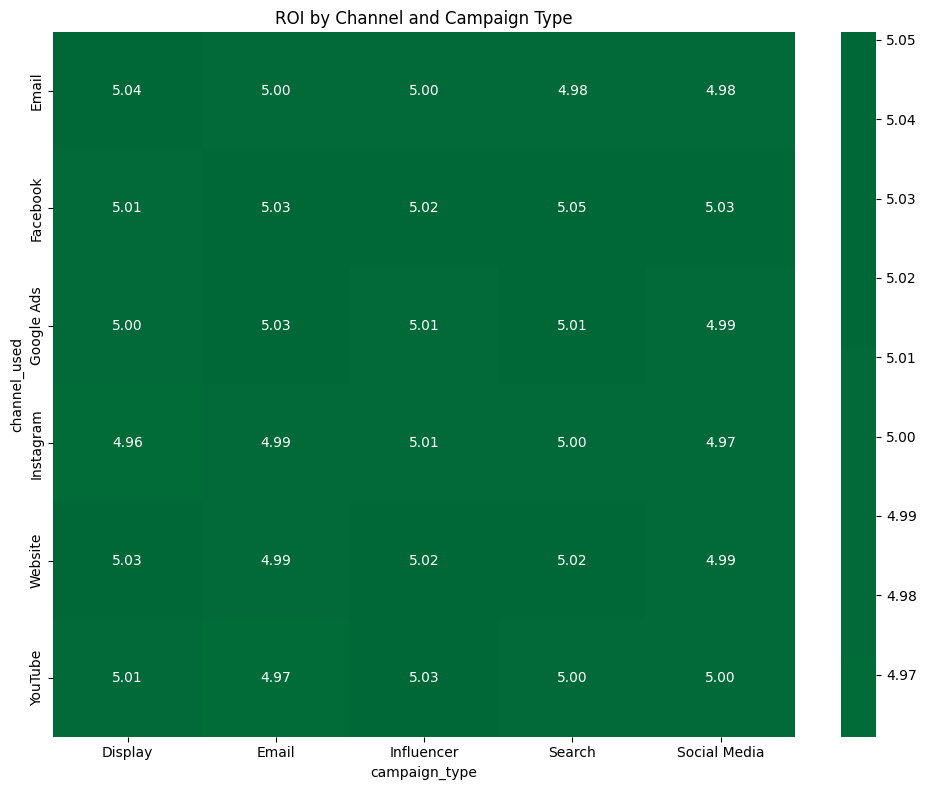

In [11]:
import seaborn as sns

# Create ROI heatmap by channel and campaign type
pivot = combo.pivot(index='channel_used', columns='campaign_type', values='roi')
plt.figure(figsize=(10, 8))
sns.heatmap(pivot, annot=True, cmap='RdYlGn', center=0, fmt='.2f')
plt.title('ROI by Channel and Campaign Type')
plt.tight_layout()
plt.savefig('roi_heatmap.png')
plt.show()

### Combination Insights:

- Email + Influencer shows the highest conversion rate (0.0814)
- Facebook + Search has the highest ROI (5.051), followed by Email + Display (5.038)
- The ROI heatmap reveals consistently high performance across all combinations (4.96-5.05)
- Facebook platform shows the strongest ROI across multiple campaign types
- The performance differences between combinations are relatively small, suggesting effective overall strategy

## Audience Value Analysis

Finding the highest-revenue audience segments.

In [12]:
seg = (
    df
      .groupby(['target_audience','customer_segment'])
      .agg({'conversions':'sum','revenue':'sum','acquisition_cost':'sum'})
)
seg['rev_per_conv']  = seg['revenue']/seg['conversions']
seg['cost_per_conv'] = seg['acquisition_cost']/seg['conversions']
seg = seg.sort_values('rev_per_conv', ascending=False)
print("Top segments by revenue per conversion:\n", seg[['rev_per_conv','cost_per_conv']].head(5))

Top segments by revenue per conversion:
                                      rev_per_conv  cost_per_conv
target_audience customer_segment                                
Women 25-34     Foodies               1730.213664     286.923413
Men 18-24       Health & Wellness     1725.841654     288.274101
All Ages        Foodies               1723.318780     285.341974
                Outdoor Adventurers   1721.344863     287.110736
Women 35-44     Fashionistas          1721.260195     287.011107


### Value Insights:

- Women 25-34 + Foodies generate the highest revenue per conversion ($1730.21)
- Men 18-24 + Health & Wellness segment shows strong value ($1725.84 per conversion)
- All Ages + Foodies segment provides good revenue ($1723.32) with lower costs 
- All top segments have similar cost efficiencies around $285-288 per conversion
- Women audience segments appear more frequently in top revenue-generating combinations

## Duration Analysis

Finding the optimal campaign length.

In [13]:
dur = (
    df
      .groupby('duration_days')
      .agg({'conversions':'sum','clicks':'sum','revenue':'sum','acquisition_cost':'sum'})
)
dur['conv_rate'] = dur['conversions']/dur['clicks']
dur['roi']       = (dur['revenue']-dur['acquisition_cost'])/dur['acquisition_cost']

print("Duration summary:\n", dur[['conv_rate','roi']])

Duration summary:
                conv_rate       roi
duration_days                     
15              0.079940  4.997002
30              0.080241  5.010040
45              0.079933  5.000979
60              0.080190  5.012734


### Duration Insights:

- 60-day campaigns show the highest ROI (5.013), closely followed by 30-day campaigns (5.010)
- 30-day campaigns have the best conversion rate (0.0802), making them the most efficient
- 15-day campaigns show the weakest performance in both ROI (4.997) and conversion rate (0.0799)
- The variation is small but consistent, with longer campaigns generally performing better
- The optimal campaign duration appears to be 30 days, balancing efficiency and strong ROI

## Time Series Analysis

Conversion rate patterns over time.

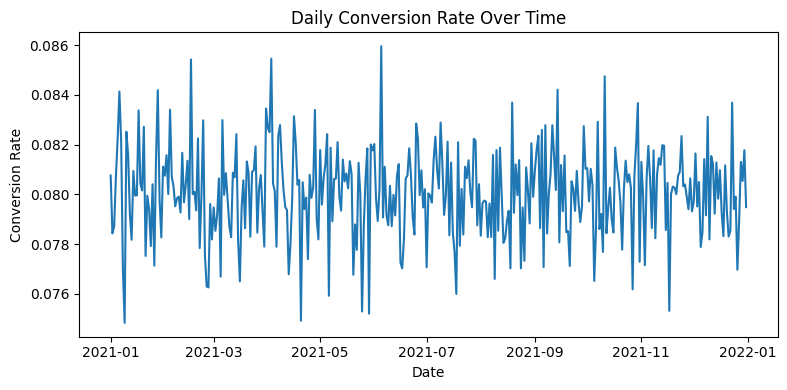

In [14]:
# Aggregate daily conversion rate
daily = df.set_index('date').resample('D').apply({
    'conversions':'sum',
    'clicks':'sum'
})
daily['daily_conv_rate'] = daily['conversions'] / daily['clicks']

# Plot
plt.figure(figsize=(8,4))
plt.plot(daily.index, daily['daily_conv_rate'])
plt.title('Daily Conversion Rate Over Time')
plt.ylabel('Conversion Rate')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig('daily_conversion_rate.png')
plt.show()

### Trend Insights:

- Conversion rates remain stable throughout the year, ranging from 0.075 to 0.086
- Occasional spikes in conversion rates reach up to 0.086, particularly in June 2021
- No clear seasonal patterns are evident in the conversion rate data
- Daily fluctuations occur but remain within a consistent band of performance
- The overall trend shows remarkable stability across the year-long period

## Conversion Funnel

Visualizing the customer journey.

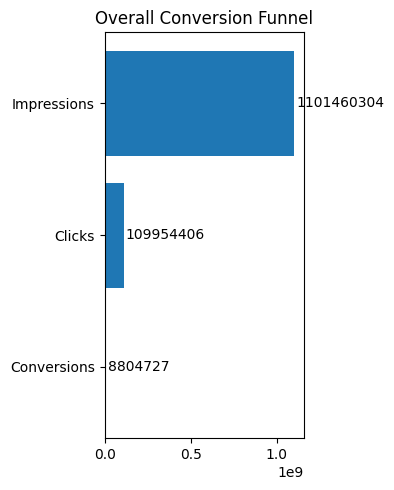

In [15]:
# Simple Matplotlib funnel
stages = ['Impressions', 'Clicks', 'Conversions']
values = [
    df['impressions'].sum(),
    df['clicks'].sum(),
    df['conversions'].sum()
]

fig, ax = plt.subplots(figsize=(4,5))
ax.barh(stages, values)
ax.invert_yaxis()
for i, v in enumerate(values):
    ax.text(v + max(values)*0.01, i, str(v), va='center')
ax.set_title('Overall Conversion Funnel')
plt.tight_layout()
plt.savefig('conversion_funnel.png')
plt.show()

### Funnel Insights:

- Massive drop-off from impressions (1.1 billion) to clicks (110 million) indicates a 10% CTR
- Click to conversion rate is 8%, resulting in 8.8 million total conversions
- For every 125 impressions, only 1 conversion is generated on average


## Key Findings & Actions

1. **Channel Performance**: Facebook and Website channels show the best overall ROI (5.03 and 5.01)
2. **Audience Targeting**: Focus on Men 25-34 (ROI: 5.02) and Foodies segment (ROI: 5.01)
3. **Campaign Combinations**: Facebook + Search (ROI: 5.05) and Email + Display (ROI: 5.04) are top performers
4. **Timing Strategy**: Thursday (ROI: 5.02) and Wednesday (ROI: 5.01) show the strongest performance
5. **Campaign Duration**: 60-day campaigns yield highest ROI (5.01), but 30-day campaigns offer best conversion rate

In [16]:
export_cols = [
    'campaign_id','company','campaign_type','target_audience','duration_days',
    'channel_used','location','language','customer_segment','date','day_of_week',
    'impressions','clicks','conversions','revenue','acquisition_cost','roi',
    'ctr','conversion_rate','rev_per_conv','cost_per_conv'
]
df[export_cols].to_csv('campaign_performance_clean.csv', index=False)
print("Exported campaign_performance_clean.csv")

Exported campaign_performance_clean.csv
